# Simple Taylor method for integrating ODEs

In this notebook, we show how `TaylorSeries` can be applied in a relatively simple way to implement the Taylor method of integration for ODEs to arbitrarily high order.

This is a pedagogical example, since the Picard integration method used is not efficient in practice. Nonetheless it is a very intuitive method.

## Picard integration

We first implement Picard integration for a single-variable Taylor series:

In [9]:
using TaylorSeries

In [10]:
∫⬩dt(u::Taylor1) = integrate(u)

∫⬩dt (generic function with 1 method)

In [11]:
function taylor_step(f, u0)

    u = copy(u0)
    unew = u0 + ∫⬩dt(f(u))

    while unew != u
        u = unew
        unew = u0 + ∫⬩dt(f(u))   # Picard iteration
    end
    
    return u
end

taylor_step (generic function with 1 method)

In [12]:
f(x) = x

degree = 3

u0 = Taylor1([1.0], degree)

soln = taylor_step(f, u0)

 1.0 + 1.0 t + 0.5 t² + 0.16666666666666666 t³ + 𝒪(t⁴)

In [13]:
soln(1.0)

2.6666666666666665

In [15]:
degree = 10
u0 = Taylor1([1.0], degree)

soln = taylor_step(f, u0)

 1.0 + 1.0 t + 0.5 t² + 0.16666666666666666 t³ + 0.041666666666666664 t⁴ + 0.008333333333333333 t⁵ + 0.001388888888888889 t⁶ + 0.0001984126984126984 t⁷ + 2.48015873015873e-5 t⁸ + 2.7557319223985893e-6 t⁹ + 2.7557319223985894e-7 t¹⁰ + 𝒪(t¹¹)

In [16]:
soln(1.0) - exp(1.0)

-2.7312660577649694e-8

In [17]:
degree = 20 
u0 = Taylor1([1.0], degree)

soln = taylor_step(f, u0)
soln(1.0) - exp(1.0)

0.0

## More variables

Now let `u0` be a vector in $\mathbb{R}^d$ and `f` a function from $\mathbb{R}^d \to \mathbb{R}^d$. In Julia we just have to broadcast the operations using `.`:

In [18]:
function taylor_step(f, u0)

    u = copy(u0)
    unew = u0 .+ ∫⬩dt.(f(u))

    while unew != u
        u = unew
        unew = u0 .+ ∫⬩dt.(f(u))
    end
    
    return u
end

taylor_step (generic function with 1 method)

An alternative would be to overload `∫⬩dt` to act on a vector and return a vector.

Note that this version of taylor_integration also works for a single variable, so it is in fact the only version that we need:

In [19]:
degree = 20
u0 = Taylor1([1.0], degree)

soln = taylor_step(f, u0)
soln(1.0) - exp(1.0)

0.0

## Taylor integration

In [29]:
TaylorSeries.displayBigO(false)

false

Let's run several time steps to perform a complete ODE integration:

In [82]:
function taylor_integrate(f, x00, t0, δt, t_final, degree=10)
    
    ts = [t0]
    xs = [x00]

    # Taylor version of initial condition for each step:
    x0 = Taylor1.(x00, degree)  
    t = t0
    
    
    while t < t_final

        x = taylor_step(f, x0)
        t += δt
        
        # evaluate Taylor series at end of step to get new initial condition: 
        xend = x(δt)

        push!(ts, t)
        push!(xs, xend)
        
        # Taylor series for new initial condition:
        x0 = Taylor1.(xend, degree)
    end
    
    return ts, xs
    
end

taylor_integrate (generic function with 2 methods)

Single variable:

In [47]:
f(β, x) = -β * x

x0 = 1.0
t0 = 0.0
δt = 0.1
t_final = 5.0

α = 0.5
@time ts, xs = taylor_integrate(x -> f(α, x), x0, t0, δt, t_final)

  0.011537 seconds (12.18 k allocations: 751.265 KiB)


([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9  …  4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5.0, 5.1], [1.0, 0.951229, 0.904837, 0.860708, 0.818731, 0.778801, 0.740818, 0.704688, 0.67032, 0.637628  …  0.122456, 0.116484, 0.110803, 0.105399, 0.100259, 0.0953692, 0.090718, 0.0862936, 0.082085, 0.0780817])

In [48]:
using Plots

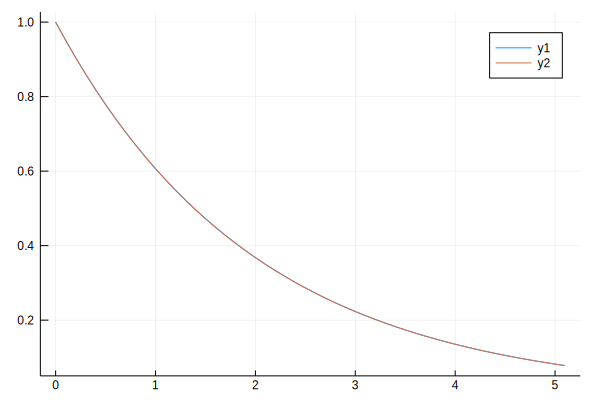

In [52]:
plot(ts, xs)
plot!(ts, t->exp(-α*t))

In [53]:
xs[end] - exp(-α * ts[end])

-9.71445146547012e-17

### Van der Pol oscillator:

In [92]:
van_der_Pol(μ, xx) = ( (x, y) = xx; [y, μ * (1 - x*x) * y - x] )

x0 = [1.0, 0.0]
t0 = 0.0
δt = 0.01
t_final = 20.0
degree = 10

μ = 3.0
@time ts, soln = taylor_integrate(x -> van_der_Pol(μ, x), x0, t0, δt, t_final, degree)

  0.097002 seconds (833.41 k allocations: 62.800 MiB, 18.55% gc time)


([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.0], Array{Float64,1}[[1.0, 0.0], [0.99995, -0.00999984], [0.9998, -0.0199988], [0.99955, -0.0299961], [0.9992, -0.0399913], [0.99875, -0.0499839], [0.9982, -0.0599737], [0.997551, -0.0699608], [0.996801, -0.0799454], [0.995952, -0.0899276]  …  [-1.94944, 0.223118], [-1.9472, 0.223855], [-1.94496, 0.224568], [-1.94271, 0.225259], [-1.94045, 0.225929], [-1.93819, 0.226582], [-1.93592, 0.227218], [-1.93365, 0.22784], [-1.93137, 0.228448], [-1.92908, 0.229045]])

In [93]:
using Plots

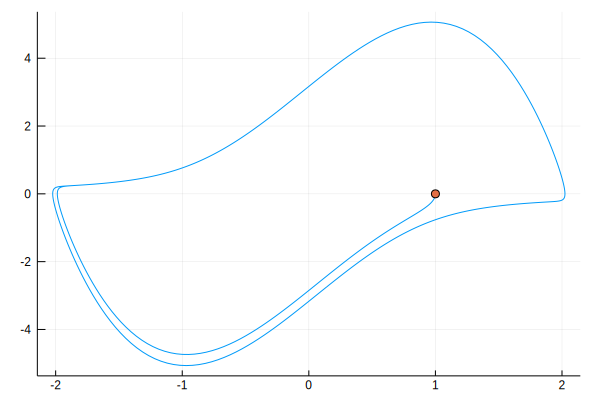

In [94]:
plot(first.(soln), last.(soln), leg=false)
scatter!([first(soln[1])], [last(soln[1])])

In [96]:
x0 = [2.0, 5.0]

@time ts, soln = taylor_integrate(x -> van_der_Pol(μ, x), x0, t0, δt, t_final, degree)

  0.083179 seconds (816.03 k allocations: 61.855 MiB, 21.22% gc time)


([0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09  …  19.91, 19.92, 19.93, 19.94, 19.95, 19.96, 19.97, 19.98, 19.99, 20.0], Array{Float64,1}[[2.0, 5.0], [2.04767, 4.53696], [2.0908, 4.09166], [2.12958, 3.66881], [2.16426, 3.27181], [2.19511, 2.90285], [2.22242, 2.56304], [2.24647, 2.25257], [2.26756, 1.97091], [2.28598, 1.71699]  …  [2.02102, -0.0825088], [2.02014, -0.0945201], [2.01914, -0.105472], [2.01803, -0.115462], [2.01683, -0.124576], [2.01554, -0.132895], [2.01417, -0.140491], [2.01273, -0.147431], [2.01123, -0.153775], [2.00966, -0.159578]])

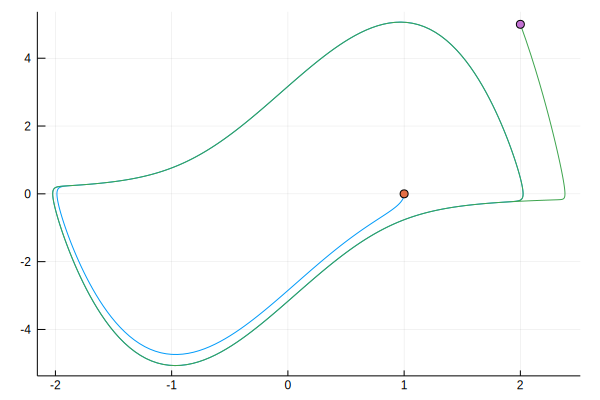

In [97]:
plot!(first.(soln), last.(soln), leg=false)
scatter!([first(soln[1])], [last(soln[1])])

## Obtaining performance

The above is a pedagogical approach. For efficiency, we should avoid re-calculating those Taylor coefficients that have previously been calculated in each step of the Picard integration. One solution for this is the `@taylorize` macro in `TaylorIntegration.jl`.